# 프로젝트: 멋진 작사가 만들기
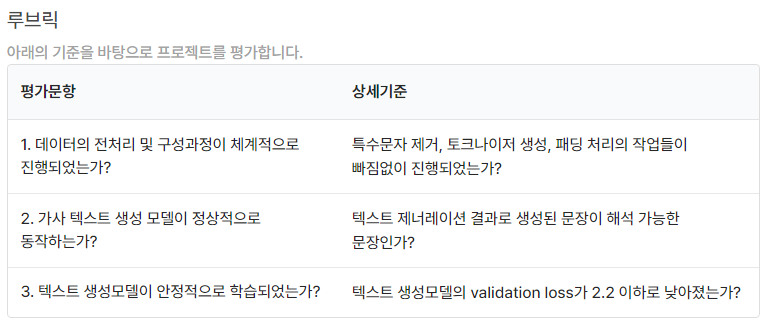

In [1]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow

print(tensorflow.__version__)

2.6.0


## Step 1. 데이터 읽어오기
glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요. glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하도록 할게요!

In [2]:
import glob
import os, re 
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:9])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]', 'You ever want something ', "that you know you shouldn't have ", "The more you know you shouldn't have it, ", 'The more you want it ', 'And then one day you get it, ', "It's so good too "]


## Step 2. 데이터 정제
앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.
그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

In [3]:
# enumerate() 함수를 이용하여 raw_corpus list 내에 저장된 문장과 그 문장의 인덱스를 반환 (인덱스, 문장 순)
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 공백 줄 건너뛰기 
    if sentence[-1] == "]": continue  # 문장의 끝이 : 인 문장은 건너뛰기 

    if idx > 9: break   # 문장 10개 확인 
        
    print(sentence)

You ever want something 
that you know you shouldn't have 
The more you know you shouldn't have it, 
The more you want it 
And then one day you get it, 
It's so good too 
But it's just like my girl 


In [4]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [5]:
# 정제된 문장을 모을 빈 리스트 
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # print(sentence)
    # 원치 않는 문장 건너 뛰기 
    if len(sentence) == 0: continue
    if sentence[-1] == "]": continue
    
    # preprocess_sentence() 함수로 정제된 문장 담기 
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 문장 10개 확인 
corpus[:10]

['<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>',
 '<start> but right now i just feel cold , so cold <end>']

## Step 3. 평가 데이터셋 분리
훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 단어장의 크기는 12,000 이상 으로 설정하세요! 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

In [6]:
# 토큰화 
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000, # 단어사전 15000개로 설정 
        filters=' ',
        oov_token="<unk>" # 단어사전에 포함되지 못한 단어는 '<unk>'로 바꿈 
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   7 156 ...   0   0   0]
 [  2  17   7 ...   0   0   0]
 [  2   6  98 ...   0   0   0]
 ...
 [  2 310   1 ...   0   0   0]
 [  2 729   5 ...   0   0   0]
 [  2 729   5 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f371a2da6d0>


In [7]:
print(tensor[:3, :10])

[[   2    7  156   62  199    3    0    0    0    0]
 [   2   17    7   34    7 1536   15   76    3    0]
 [   2    6   98    7   34    7 1536   15   76   11]]


In [8]:
# 단어사전 10개 확인 
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


단어 사전의 2번이 \<start>라서 위의 토큰화시킨 문장에 2가 많다는 것을 알 수 있다. 

In [9]:
# 이 코드 이해 안됨 
# tensor의 마지막 토큰 잘라내 소스 문장 생성
src_input = tensor[:, :-1]  
# tensor의 <start> 잘라내 타겟 문장을 생성
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2   7 156  62 199   3   0   0   0   0   0   0   0   0   0   0   0   0
   0]
[  7 156  62 199   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


In [10]:
# 이 코드 이해 안됨 
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 7000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

In [11]:
# train, validation 분리 
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, random_state=2023, test_size=0.2)

print("enc_train shape: {}".format(enc_train.shape))
print("dec_train shape: {}".format(dec_train.shape))
print("enc_val shape: {}".format(enc_val.shape))
print("dec_val shape: {}".format(dec_val.shape))

enc_train shape: (139790, 19)
dec_train shape: (139790, 19)
enc_val shape: (34948, 19)
dec_val shape: (34948, 19)


## Step 4. 인공지능 만들기
모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요!

잘 설계한 모델을 학습하려면, model.fit() 함수를 사용해야 합니다. model.fit() 함수에는 다양한 인자를 넣어주어야 하는데, 가장 기본적인 인자로는 데이터셋과 epochs가 있습니다. '5. 실습 (2) 인공지능 학습시키기'에서의 예시와 같이 말이죠. 
```python
model.fit(dataset, epochs=30)
```
하지만 model.fit() 함수의 epochs를 아무리 크게 넣는다 해도 val_loss 값은 2.2 아래로 떨어지지 않습니다. 이럴 경우는 batch size를 변경하는 것과 같이 model.fit() 함수에 다양한 인자를 넣어주면 해결될 수도 있습니다. 자세한 내용은 https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit 를 참고하세요!

Loss는 아래 제시된 Loss 함수를 그대로 사용하세요!

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 512  # 단어가 추상적으로 표현되는 크기, 클수록 추상적인 특징을 잡아낼 수 있음    
hidden_size = 1024    # 모델의 일꾼 수 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # +1은 pad

In [13]:
# 데이터 한 배치만 샘플로 불러오기
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치를 모델에 넣어보기
model(src_sample)

<tf.Tensor: shape=(256, 19, 15001), dtype=float32, numpy=
array([[[-3.16697173e-04,  1.03122846e-04, -9.28934678e-05, ...,
          2.95229955e-04,  2.70994089e-04, -8.89371149e-05],
        [-2.83350324e-04, -1.21909834e-05, -5.28550532e-04, ...,
          6.57371420e-04,  5.55844803e-04,  2.44358034e-05],
        [-5.51829056e-04, -2.98309198e-04, -8.90537282e-04, ...,
          8.29286932e-04,  8.16453423e-04, -1.17240716e-05],
        ...,
        [-1.82665617e-03,  1.33792555e-03, -3.52532748e-04, ...,
          1.04158756e-03,  3.43902106e-03, -1.15319167e-03],
        [-2.08647014e-03,  1.30900438e-03, -3.06449598e-04, ...,
          1.03027513e-03,  3.83504247e-03, -1.42854929e-03],
        [-2.32157088e-03,  1.28818746e-03, -2.59966619e-04, ...,
          1.02149497e-03,  4.19732230e-03, -1.68045447e-03]],

       [[-3.16697173e-04,  1.03122846e-04, -9.28934678e-05, ...,
          2.95229955e-04,  2.70994089e-04, -8.89371149e-05],
        [-6.58670731e-04,  1.72826083e-04, -1

In [14]:
# 모델 구조 
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  7680512   
_________________________________________________________________
lstm (LSTM)                  multiple                  6295552   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  15376025  
Total params: 37,744,793
Trainable params: 37,744,793
Non-trainable params: 0
_________________________________________________________________


In [15]:
# learning_rate=0.005
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none')

In [16]:
model.compile(loss=loss, optimizer=optimizer) 

In [17]:
# 모델 학습 
# 01 : RMSprop, epochs=5, batch_size=32, verbose=2 => val_loss: 3.8194
# 02 : RMSprop, epochs=15, batch_size+verbose 제거 => val_loss: 4.5113
# 03 : RMSprop, epochs=15, batch_size=32, learning_rate=0.001 => val_loss: 4.6353 
# 04 : Adam, epochs=30, batch_size=32, learning_rate=0.001 => val_loss: 3.0826
# 05 : Adam, epochs=50, batch_size=32, learning_rate=0.0001 =>  val_loss: 3.0224에서 계속 증가하는 overfitting 발생 
# 06 : ★ Adam, epochs=20, batch_size=16, learning_rate=0.005 => epoch 3 val_loss: 2.2741 이후로 계속 증가 
# 07 : Adam, epochs=15, batch_size=16, learning_rate=0.01 => val_loss: 2.5094에서 계속 증가
# 08 : Adam, epochs=15, batch_size=32, learning_rate=0.005 => epoch7에서 val_loss: 2.8279 내려갔다가 3.0313로 마무리 
# 09 : Adam, epochs=30, batch_size=8, learning_rate=0.005 => val_loss: 3.1830에서 계속 증가
# 10 : Adam, epochs=15, batch_size=32, learning_rate=0.005 => val_loss: 3.1066에서 계속 증가
# 11 : Adam, epochs=15, batch_size=256, learning_rate=0.005 => val_loss: 3.1106에서 계속 증가
# 12 : Adam, epochs=steps_per_epoch(682), batch_size=256, learning_rate=0.005 => val_loss: 3.0911에서 계속 증가
# 12 : Adam, epochs=15, batch_size=256, learning_rate 없앰 => val_loss: 3.0862에서 안 떨어짐 
# 13 : Adam, epochs=30, batch_size=2048, learning_rate 없앰 => val_loss: 3.0858에서 안 떨어짐 
# 14 : embedding_size = 512, Adam, epochs=20, batch_size=2048, learning_rate=0.005 => 

model.fit(enc_train, dec_train, epochs=20, batch_size=2048, validation_data=(enc_val, dec_val))

Epoch 1/20
69/69 [==============================] - 155s 2s/step - loss: 3.7819 - val_loss: 3.0847
Epoch 2/20
69/69 [==============================] - 153s 2s/step - loss: 2.9185 - val_loss: 2.8588
Epoch 3/20
69/69 [==============================] - 154s 2s/step - loss: 2.7498 - val_loss: 2.6237
Epoch 4/20
69/69 [==============================] - 155s 2s/step - loss: 2.5079 - val_loss: 2.4537
Epoch 5/20
69/69 [==============================] - 155s 2s/step - loss: 2.3625 - val_loss: 2.3580
Epoch 6/20
69/69 [==============================] - 155s 2s/step - loss: 2.2543 - val_loss: 2.2900
Epoch 7/20
69/69 [==============================] - 155s 2s/step - loss: 2.1602 - val_loss: 2.2382
Epoch 8/20
69/69 [==============================] - 156s 2s/step - loss: 2.0728 - val_loss: 2.1844
Epoch 9/20
69/69 [==============================] - 156s 2s/step - loss: 1.9881 - val_loss: 2.1424
Epoch 10/20
69/69 [==============================] - 155s 2s/step - loss: 1.9055 - val_loss: 2.1088
Epoch 11/

validation_data(enc_val, dec_val)으로 돌리니 SyntaxError: positional argument follows keyword argument 에러가 나왔다. =을 넣어 지정을 해줘야한다. 



verbose = 학습 중 출력되는 문구 설정
- 0 : 아무 것도 출력하지 않음
- 1 : 훈련의 진행도를 보여주는 진행 막대를 보여줌
- 2 : 미니 배치마다 손실 정보 출력   
=> 해보니까 verbose 없는게 제일 보기 좋음 

Ref.   
https://wikidocs.net/32105


모델 학습 초반부터 계속 val_loss가 지속적으로 증가하는 overfitting 문제가 생겼다.   
    
    

추측할 수 있는 원인과 대책   
1) 모델이 너무 크다 => 이 모델은 별로 크지 않다    
2) learning rate이 너무 크거나 작다 => 0.0001과 0.001을 써봤는데 조금 늘려봐야겠다. learning rate scheduler 라는 것도 있다    
3) dropout, batch normalization을 추가하는 것도 한 방법    
4) batch size를 늘리거나 줄이고, epoch=20 이상까지 지켜본다 


Ref.   
https://ysyblog.tistory.com/111 

In [31]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=100): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [32]:
# 가사 생성1
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=100)

'<start> i love you , baby <end> '

In [33]:
# 가사 생성2
generate_text(model, tokenizer, init_sentence="<start> if i were you", max_len=100)

'<start> if i were you , i d be known <end> '

In [34]:
# 가사 생성3
generate_text(model, tokenizer, init_sentence="<start> when we were young", max_len=100)

'<start> when we were young and we re not old <end> '

In [35]:
# 가사 생성4
generate_text(model, tokenizer, init_sentence="<start> let me potograph you in this light", max_len=100)

'<start> let me <unk> you in this light <end> '

생성된 가사가 어느정도 말이 되긴 하는데, 생각보다 많이 실망스럽다.    
가사가 너무 짧기도 하고, 기존에 학습하지 않았거나 드물게 등장하는 단어는 모두 \<unk>로 처리해버려 길게 출력된다면 이해할 수 없다.    

## 회고

**헤맨 부분** 
- 노드의 코드들을 해석하지 못해서 train_test_split 할 때 X와 y 대신 뭘 넣어줘야하는지 몰랐다. 지영님 도움으로 바로 위 코드의 src_input, tgt_input이 각각 학습 시의 문제와 정답임을 알았다. 
- 기존에 하던대로 model.fit에 train만 돌리고 나중에 그래프로 validation과 train을 비교하면 되는 줄 알았는데, metrics가 없어서 history로 그래프를 볼 수가 없다. train과 val을 같이 돌려서 val_loss를 줄이는게 루브릭의 목적 중 하나라 처음부터 같이 돌렸어야한다. 
- model.fit에 validation을 설정하니까 syntax error가 났다. =이 빠져서 난 에러였다. 
- 하이퍼파라미터를 계속 조절하며 모델 학습을 시켰는데, epoch 1일때부터 계속 val_loss가 증가한다. 처음부터 overfitting될 것 같지는 않고 이게 무슨 의미일까?

**문제를 해결하기 위한 시도와 원인 추론**
- 노드의 코드를 따왔더니 첫번째 줄인 [Spoken Intro:]과 같이 의미없는 부분을 삭제되지 않았다. 코드를 sentence[-2] == ":"로 변경해주었더니 enumerate 코드에서는 괜찮았는데, sentence 코드에서는 IndexError가 났다. 진표님 도움으로 sentence for문에 print(sentence)를 넣어 확인해보니 I와 같이 한 줄에 알파벳 1개인 경우가 있어 인덱스 [-2]가 없는게 원인이었다. sentence[-1] == "]"로 변경해서 해결했다.
- model.fit에서 첫 에폭부터 val_loss가 증가하는 문제가 발생했다. 모델 구성 자체를 바꾸기 전에 일단 너무 작았던 learing rate을 늘리고 , batch size를 줄여주었다. 
- val_loss가 2.2이하로 떨어지지 않아 하이퍼파라미터를 조절해 여러번 시도해보았는데, 혼자 힘으로는 계속 실패했다. 소명님 추천으로 batch size를 2048로 확 늘리고, embedding size를 512로 바꾸니 val_loss가 1점대로 떨어졌다. 문장이 많고 단어가 다양하므로 추상성을 파악하기 위해 embedding size를 더 키워줘야하는 것 같다. 

**새롭게 알게된 부분**
- model.fit 할 때 원래 하던대로 history = 형식으로 만들었는데, 가사를 만들어내는 모델은 평가지표로 평가할 수 없으니 histroy로 그래프를 뽑아보는게 의미 없다. 평가는 사람이 하는 수 밖에..
- metrics 옵션 없이도 모델을 학습시킬 수 있구나!
- metrics와 test가 없으니 evaluate하고 predict를 할 이유가 없다. 
- 데이터 사이즈가 클 때는 batch size를 크게 잡아보고, embedding size도 조절한다. 

**아직도 모르는 부분**
- 작사 인공지능은 모델 구성을 어떻게 바꿔야 성능을 높이 수 있을까? 
- model(src_sample) 코드에서 왜 굳이 샘플 뽑아서 모델에 넣어보는걸까?
- 다른 하이퍼파라미터가 동일할 때 epoch = 30 중 20의 val_loss와 epoch = 20의 마지막 val_loss는 왜 다를까? kernerl restart를 하면 똑같을까? 모델 돌리는데 시간이 너무 많이 걸려서 시도를 못해보겠다. 